In [1]:
import random
import json_lines
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import KeyedVectors
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

LIMIT_INPUT_ROWS= 300
MIN_ENGLISH= 0.0
WNL = WordNetLemmatizer()
REMOVEABLE_CHARS= '[^A-Za-z ]'
ALL_TAGS= ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS= ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
MIN_WORD_OCCURRENCES= 1
VEC_SIZE= 20
MAX_GRAMS= 4
AMOUNT_OF_FILTS= 50 # put to 100 probably

number_entries= 0
with open ('reviews.json', 'rb') as f:
    for item in json_lines.reader(f):
        number_entries+= 1

In [2]:
# READ IN INFO
reviews= []; polarity= []; are_early= []
included_indexs= []
j= 0
while j < LIMIT_INPUT_ROWS:
    randint= random.randint(0, number_entries-1)
    if not randint in included_indexs:
        included_indexs.append(randint)
        j+= 1
    
with open('reviews.json', 'rb') as f: # 5,000 entries in reviews.json
    for counter, item in enumerate(json_lines.reader(f)):
        if counter in included_indexs:
            reviews.append(item['text'])
            polarity.append(item['voted_up'])
            are_early.append(item['early_access'])

# END PRODUCTS: reviews, polarity, are_early

In [3]:
# FILTER TEXT BY CHARACTER

import re
new_reviews= []
for i, text in enumerate(reviews):
    text= re.sub(REMOVEABLE_CHARS, '', text)
    if not str.isspace(text) and text != "":
        new_reviews.append(text)
#     else:
#         print("removed ["+text+"]")
# print(reviews)
# print("########################################################################")
# print(new_reviews)
reviews= new_reviews

# END PRODUCTS: reviews

In [4]:
# FILTER TEXT BY LANGUAGE

filtered_reviews= []
filtered_polarity= []
filtered_are_early= []
for i, text in enumerate(reviews):
    try:
        langs = detect_langs(text)
    except:
        print("["+text+"]")
        print("ERROR: langs failed to define itself. Happens occassionally - just rerun")
        pass
    for lang in langs:
        if str(lang)[0:2] == 'en':
            if float(str(lang)[3:]) > MIN_ENGLISH:
                filtered_reviews.append(reviews[i])
                filtered_polarity.append(polarity[i])
                filtered_are_early.append(are_early[i])
reviews= filtered_reviews
polarity= filtered_polarity
are_early= filtered_are_early

#print(reviews)
# END PRODUCTS: reviews, polarity, are_early

In [5]:
# FILTER TEXT BY WORD TYPE

#print(reviews)
filtered_reviews= []
for i, text in enumerate(reviews):
    #print("-------------------------------------")
    new_text= []
    split_text= text.split()
    tags= nltk.pos_tag(split_text)
    #print(tags)
    #print("#############")
    lemd_split_text= []
    for word in split_text:
        lemd_split_text.append(WNL.lemmatize(word))
    tags= nltk.pos_tag(lemd_split_text)
    #print(tags)
    for j, word in enumerate(lemd_split_text):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    filtered_reviews.append(new_text)
reviews= [' '.join([str(elem) for elem in sublist]) for sublist in filtered_reviews]

# END PRODUCTS: reviews, polarity, are_early

In [6]:
# GET REVIEWS AS LIST OF LISTS

no_sentences= 0
reviews_as_ll= [] # ll denoting the list of list data
for text in reviews:
    split_text= text.split()
    reviews_as_ll.append(split_text)
    no_sentences+= 1

# END PRODUCTS: reviews_as_ll, no_sentences

In [7]:
# MAKE REVIEWS LOWER CASER

for i, review in enumerate(reviews_as_ll):
    for j, word in enumerate(review):
        reviews_as_ll[i][j]= word.lower()

# END PRODUCTS: reviews_as_ll

In [8]:
# MODEL RELATED

#X_train, X_test, y_train, y_test= train_test_split(reviews_as_ll, polarity, test_size=0.33, random_state=42)

model= gensim.models.Word2Vec(min_count= MIN_WORD_OCCURRENCES, vector_size=VEC_SIZE)
model.build_vocab(reviews_as_ll)
model.train(reviews_as_ll, total_examples=no_sentences, epochs=model.epochs) # can be a non-repeatable, 1-pass generator

# Store just the words + their trained embeddings.
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

# END PRODUCTS: wv

In [9]:
# MAKE FILTERS

filters= []
for i in range(AMOUNT_OF_FILTS):
    filter= []
    n_gram= random.randint(2, MAX_GRAMS)
    for j in range(n_gram):
        filter_layer= []
        for k in range(VEC_SIZE):
            filter_layer.append(random.uniform(-1, 1))
        filter.append(filter_layer)
    filter= np.array([np.array(xi) for xi in filter])
    filters.append(filter)

# END PRODUCTS: filters (list of numpy.ndarray)

In [10]:
# GENERATE FEATURES

# rows, cols = (len(reviews_as_ll), AMOUNT_OF_FILTS)
# greatest_activations = [[0]*cols]*rows # greatest (absolute) filter activation values
greatest_activations= {}
# dict_name[(conv_i, filt_i)] = greatest_conv_float

for review_i, review in enumerate(reviews_as_ll):
    for filt_i, filt in enumerate(filters):
        filt= filt.ravel()
        greatest_conv_value= 0
        n_gram= round(filt.size / VEC_SIZE) # round being used to convert to int
        convolutions_per_filt= len(review) - n_gram + 1
        for convolution_i in range(convolutions_per_filt):
            vec_matrix= []
            for i in range(n_gram):
                vec_matrix.append(wv[review[convolution_i + i]]) # WV is a dict
            vec_matrix= np.array([np.array(xi) for xi in vec_matrix]).ravel() # list of lists to 1d nd numpy
            conv_result= np.convolve(filt, vec_matrix, 'valid')
            if abs(conv_result) > abs(greatest_conv_value):
                greatest_conv_value= conv_result
        if type(greatest_conv_value) != int:
            greatest_conv_value= greatest_conv_value[0].astype(float).item()
        if type(greatest_conv_value) == int:
            greatest_conv_value= np.float64(greatest_conv_value).item()
        #print(type(greatest_conv_value))
        #greatest_activations[review_i][filt_i]= greatest_conv_value
        greatest_activations[(review_i, filt_i)]= greatest_conv_value
        #print(review_i, filt_i, " = ", greatest_conv_value)
        #print(greatest_conv_value)

amount_rows= round(len(greatest_activations) / AMOUNT_OF_FILTS)
greatest_activations_as_ll= []
for i in range(amount_rows):
    next_list= []
    for j in range(AMOUNT_OF_FILTS):
        next_list.append(greatest_activations[i, j])
    greatest_activations_as_ll.append(next_list)
    
# END PRODUCTS: greatest_activations_as_ll

In [11]:
clf= MLPClassifier(random_state=1, max_iter=1000).fit(greatest_activations_as_ll, polarity)
y_pred= clf.predict(greatest_activations_as_ll)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


overall accuracy:  0.9848484848484849


Text(0.5, 0.98, 'Confusion Matrix')

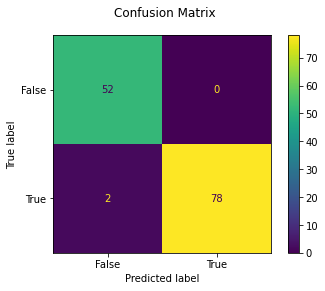

In [12]:
print("overall accuracy: ", clf.score(greatest_activations_as_ll, polarity))
fig= plot_confusion_matrix(clf, greatest_activations_as_ll, polarity)
fig.figure_.suptitle("Confusion Matrix")